# HW3

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

import importlib
import utils as ut
importlib.reload(ut)

<module 'utils' from '/Users/chuan/github/0_Quantitative_Portfolio_Manager/homework/utils.py'>

# 1. Modeling Volatility and VaR

Use the returns on the S&P 500 ($r_M$) and 1-month T-bills ($r_f$) provided in **"barnstable analysis data.xlsx"**.

For the full sample of SPY returns, 1926-2023, calculate the **level** (not log) excess market returns (against the treasury returns). We use this level excess return data throughout this section.

## 1.1. Historic VaR

Starting at $t = 61$, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to $t-1$. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t-1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $\tilde{r}^{VaR, 0.05}_{t,historic}$, which is the best estimate of the time-$t$ VaR based on data through $t-1$.

1. Plot $\tilde{r}^{VaR, 0.05}_{t,historic}$ over time.
2. Calculate the frequency of periods in which $\tilde{r}_t < \tilde{r}^{VaR, 0.05}_{t,historic}$.
3. What drawbacks do you see in this historic VaR?


In [2]:
file_path = './../data/barnstable_analysis_data.xlsx'

data = pd.read_excel(file_path, sheet_name='data').set_index('date').fillna(method='ffill')
data['excess_returns'] = data['SPX'] - data['TB1M']

rets = data['excess_returns']

data

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109
...,...,...,...
2023-04-28,0.0150,0.0035,0.0115
2023-05-31,0.0053,0.0041,0.0012
2023-06-30,0.0670,0.0043,0.0627


In [3]:
# not good
def get_historic_VaR(returns, t_start=60, quantile=0.05):
    """Returns the historic Value at Risk (VaR) of a series of data."""
    VaRs = pd.DataFrame(index=returns.index[t_start:])

    for t in range(t_start, len(returns)):
        returns_window = returns.iloc[:t]
        VaRs.loc[returns.index[t], "VaR"] = returns_window.quantile(quantile)

    return VaRs

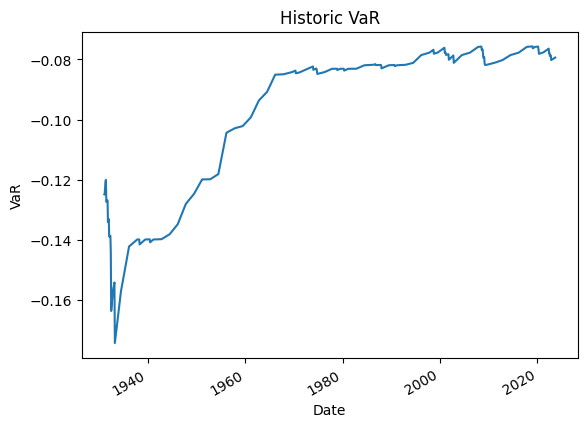

In [4]:
historic_VaR = rets.shift().expanding(min_periods=60).quantile(0.05)
historic_VaR.plot(title='Historic VaR', ylabel='VaR', xlabel='Date');

In [5]:
exceedance_rate = sum(rets < historic_VaR) / len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceedance_rate))

5% VaR backtest: 3.15%


Drawbacks of Historic VaR
1. **Backward Looking**: Relies solely on past data, assuming it predicts future losses. Insufficient or outdated data reduces relevance.
2. **Ghosting Effect**: Assigns equal weight to all past observations, including irrelevant events (e.g., 2008 crisis).
3. **Slow to React**: Recent significant losses have the same weight as older data, delaying adaptation to new market conditions.

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use σt to denote our estimate of the time-t return volatility, as based on data over periods 1 (Jan 1926) through $t − 1$, but not including $t$ itself.

- Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$

Begin the calculation at t = 61, so that the first estimate is based on 60 data points.


- Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use m = 60, and begin the calculation at the t = 61, (so that the calculation has a full 60 data points.)


- a. For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)
- b. For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping µ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t,vol} = −1.65 \sigma_t$$
- c. For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,vol}$

- d. Compare and contrast your results among each other and relative to the historic method in the previous problem.

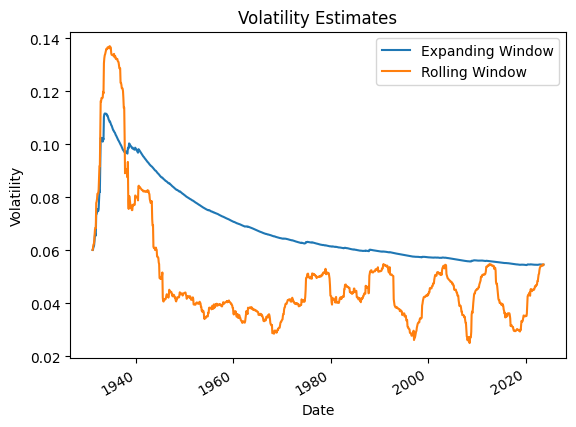

In [6]:
expanding_window_vol = rets.pow(2).expanding(60).mean().shift().pow(0.5)
rolling_window_vol = rets.pow(2).rolling(60).mean().shift().pow(0.5)

volatility_estimates = pd.DataFrame({
    'Expanding Window': expanding_window_vol,
    'Rolling Window': rolling_window_vol
})

volatility_estimates.plot(title='Volatility Estimates', ylabel='Volatility', xlabel='Date')
plt.show()

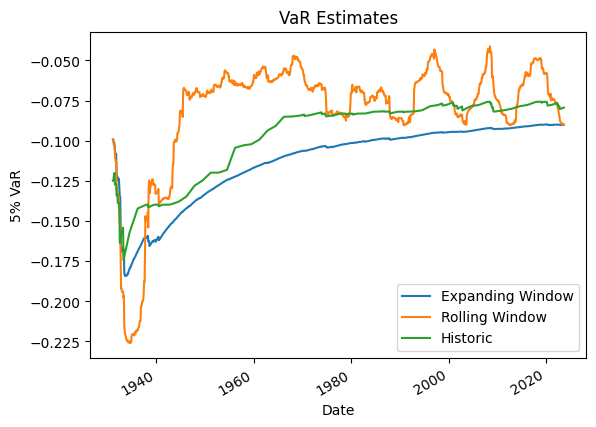

In [7]:
z = -1.65
expanding_window_VaR = z * expanding_window_vol
rolling_window_VaR = z * rolling_window_vol

VaR_estimates = pd.DataFrame({
    'Expanding Window': expanding_window_VaR,
    'Rolling Window': rolling_window_VaR,
    'Historic': historic_VaR
})

VaR_estimates.plot(title='VaR Estimates', ylabel='5% VaR', xlabel='Date')
plt.show()

In [8]:
exceedance_rate_expanding = sum(rets < expanding_window_VaR) / len(expanding_window_VaR.dropna())
exceedance_rate_rolling = sum(rets < rolling_window_VaR) / len(rolling_window_VaR.dropna())

exceedance_rates = pd.DataFrame({
    'VaR Type': ['Expanding Window', 'Rolling Window', 'Historic'],
    'Exceedance Rate': [
        exceedance_rate_expanding,
        exceedance_rate_rolling,
        exceedance_rate
    ]
})

exceedance_rates['Exceedance Rate'] = exceedance_rates['Exceedance Rate'].apply(lambda x: f"{x:.2%}")
exceedance_rates

,VaR Type,Exceedance Rate
0,Expanding Window,1.80%
1,Rolling Window,4.95%
2,Historic,3.15%


## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for q = .05.) That is, calculate CVaR for
    
- the empirical cdf
- the normal model, using expanding volatility estimates
- the normal model, using rolling volatility estimates

In [9]:
rets.expanding(60).mean()

date
1926-01-30      NaN
1926-02-27      NaN
1926-03-31      NaN
1926-04-30      NaN
1926-05-28      NaN
              ...  
2023-04-28   0.0068
2023-05-31   0.0068
2023-06-30   0.0069
2023-07-31   0.0069
2023-08-31   0.0069
Name: excess_returns, Length: 1172, dtype: float64

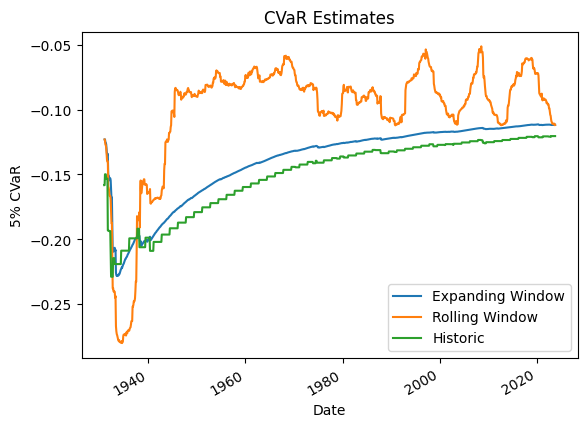

In [10]:
z = -1.65
q = 0.05
historic_CVaR = rets.expanding(60).apply(lambda x: x[x < x.quantile(q)].mean())
expanding_window_CVaR = -norm.pdf(z) * expanding_window_vol / q
rolling_window_CVaR = -norm.pdf(z) * rolling_window_vol / q

CVaR_estimates = pd.DataFrame({
    'Expanding Window': expanding_window_CVaR,
    'Rolling Window': rolling_window_CVaR,
    'Historic': historic_CVaR
})

CVaR_estimates.plot(title='CVaR Estimates', ylabel='5% CVaR', xlabel='Date')
plt.show()

## 1.4 Extra
We may discuss this after Midterm 1, but it is not part of the Midterm 1 material.

For the VaR calculations of Problem 1.2, and 1.3 try using the following models to estimate volatility:
- <b> Exponentially Weighted Moving Average (EWMA) </b>

    $$
    \sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
    $$

    Rather than estimating θ, simply use θ = 0.97, and initialize with σ1 = 0.15.



- <b> GARCH(1,1) model </b>
    To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.18374588
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.463412480511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


,Frequency
Expanding Window,1.80%
Rolling Window,4.95%
GARCH,2.97%
EWMA,4.05%
Historic,3.15%


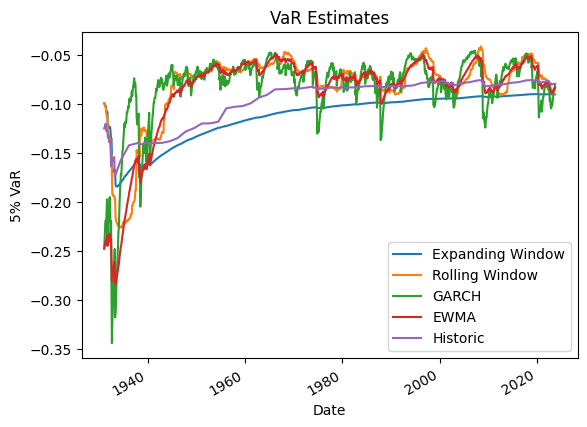

In [11]:
# Fit GARCH(1,1) model
garch_model = arch_model(rets, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
garch_params = garch_model.params

# EWMA settings
theta = 0.97
sigma1 = 0.15

# Available dates
avail_dates = volatility_estimates.dropna().index

# Initialize GARCH and EWMA series
garch = pd.Series(index=avail_dates, name='GARCH')
ewma = pd.Series(index=avail_dates, name='EWMA')
garch.iloc[0] = sigma1
ewma.iloc[0] = sigma1

# Iterative variance calculation
for i, ind in enumerate(avail_dates[1:], 1):
    # GARCH variance update
    garch.iloc[i] = np.sqrt(
        garch_params['omega'] +
        garch.iloc[i-1]**2 * garch_params['beta[1]'] +
        rets.loc[ind]**2 * garch_params['alpha[1]']
    )
    # EWMA variance update
    ewma.iloc[i] = np.sqrt(
        theta * ewma.iloc[i-1]**2 + (1 - theta) * rets.loc[ind]**2
    )

# Combine and calculate VaR
volatility_estimates = pd.concat([volatility_estimates, garch, ewma], axis=1).dropna()
VaR = -1.65 * volatility_estimates
VaR['Historic'] = historic_VaR

# Plot VaR estimates
VaR.plot(title='VaR Estimates', ylabel='5% VaR', xlabel='Date')

# Calculate exceedance frequency
var_temp = VaR.dropna()
frequency = var_temp.apply(
    lambda x: rets[var_temp.index] < x
).mean(numeric_only=True).to_frame('Frequency')

# Format and display frequency
frequency.style.format('{:,.2%}')

# 3. Estimating Underperformance

Use the returns on the S\&P $500\left(r^M\right)$ and 1-month T-bills, $\left(r^f\right)$ provided in "barnstable_analysis_data.xlsx".
Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999 . We consider this subsample, as well as 2000-2023, as well as the full sample of 1926-2023. We only have data through August of 2023, but no adjustment is needed for the fact that you have only the partial year-just use what you have.

## 3.1 Summary Statistics
- (a) Report the following (annualized) statistics.

|  |  | $1965-1999$ | $2000-2023$ | $1926-2023$ |
| :---: | :---: | :---: | :---: | :---: |
|  |  | mean vol | mean vol | mean vol |
| levels | $r^M$ |  |  |  |
|  | $\tilde{r}^M$ |  |  |  |
|  | $r^f$ |  |  |  |
| $\log s$ | $\mathrm{r}^M$ |  |  |  |
|  | $\tilde{\mathbf{r}}^M$ |  |  |  |
|  | $\mathrm{r}^f$ |  |  |  |

- (b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.

Arithmetic Return:
$$r_{\text{arithmetic}} = \frac{P_t - P_{t-1}}{P_{t-1}}$$
Log Return:
$$r_{\text{log}} = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Key Points:
- **Log Returns** are more appropriate for financial modeling due to their **additivity** and **mathematical properties**.
- If you have **percentage changes** or **arithmetic returns**, you can approximate log returns as:
  $$r_{\text{log}} \approx \ln(1 + r_{\text{arithmetic}})$$

In [33]:
agg_years = [(1965, 1999), (2000, 2023), (1926, 2023)]

def calc_analytics_by_year(data, periods):
    results = []
    period_labels = []
    
    for start, end in periods:
        subset = data.loc[f"{start}":f"{end}"]
        results.append({
            'mean': subset.mean() * 12,  # Annualized mean
            'vol': subset.std() * np.sqrt(12)  # Annualized volatility
        })
        period_labels.append(f"{start} - {end}")
    
    return pd.DataFrame(results, index=period_labels).stack()

sum_stats = data.apply(calc_analytics_by_year, periods=agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, periods=agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats], keys=['levels', 'logs'])
res_stats.style.format('{:,.2%}')

Full sample estimates are significantly different for the excess returns, this is because of the low risk-free rate during that period. The log returns show lower mean returns as expected.

## 3.2 Recall the following...
- If $x \sim \mathcal{N}\left(\mu_x, \sigma_x^2\right)$, then
$$
\begin{aligned}
\operatorname{Pr}[x<\ell] & =\Phi_{\mathcal{N}}(L) \\
L & =\frac{c-\mu_x}{\sigma_x}
\end{aligned}
$$
where $\Phi_{\mathcal{N}}$ denotes the standard normal cdf.
- Remember that cumulative log returns are simply the sum of the single-period log returns,
$$
\mathrm{r}_{t, t+h}^M \equiv \sum_{i=1}^h \mathrm{r}_{t+i}^M
$$
- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$,
$$
\overline{\mathrm{r}}_{t, t+h}^M=\frac{1}{h} \sum_{i=1}^h \mathrm{r}_{t+i}^M
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return. ${ }^2$
$$
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] \qquad...\qquad Equ. (1)
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.
- (a) Calculate (1) using the subsample 1965-1999.
- (b) Report the precise probability for $h=15$ and $h=30$ years.
- (c) Plot the probability as a function of the investment horizon, $h$, for $0<h \leq 30$ years.

**Note for solving (a):**

$$
\begin{aligned}
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] &= \operatorname{Pr}\left[\log (R_{t, t+h}^M) - \log (R_{t, t+h}^f) < 0 \right] = \operatorname{Pr}\left[ \mathrm{r}_{t, t+h}^M - \mathrm{r}_{t, t+h}^f < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^M - \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^f < 0 \right] = \operatorname{Pr}\left[ \sum_{i=t}^{t+h}(\mathrm{r}_{i}^M - \mathrm{r}_{i}^f) < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}\tilde{\mathrm{r}}_{i} < 0 \right] = \operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] \\
\end{aligned}
$$

Let annualized mean and volatility of log excess return as $\mu$ and $\sigma$, then we can see

$$
\tilde{\mathrm{r}}_{t, t+h} \sim \mathcal{N}\left(h\mu, h\sigma^2\right)
$$

As such,

$$
\operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] = 
\operatorname{Pr}\left[ Z < \frac{-h\mu}{\sqrt{h}\sigma} \right] \\
= \Phi_{\mathcal{N}}\left(-\sqrt{h}\frac{\mu}{\sigma}\right)
$$

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


<Axes: >

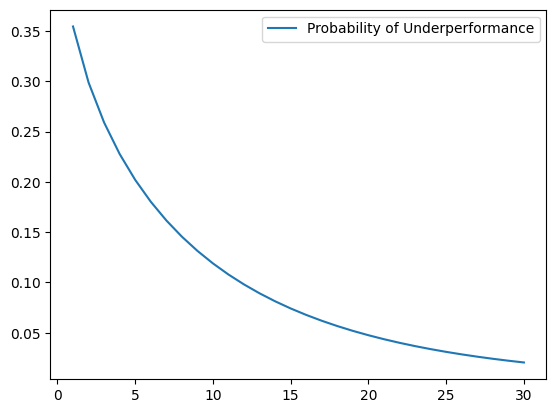

In [27]:
def prob(mu, sigma, h):
    return norm.cdf(-h**0.5 * mu / sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]
print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu, sigma, 15):,.2%}')
print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu, sigma, 30):,.2%}')

# precise probability
h = np.arange(1, 31)
probabilities = pd.DataFrame(prob(mu, sigma, h), index=h, columns=['Probability of Underperformance'])
probabilities.plot()

## 3.3

Use the sample 1965-2023 to reconsider the 30-year probability. As of the end of 2023, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t, t+h}^M$ underperforming $R_{t, t+h}^f$ for $0<h \leq 30$.

SPX underperforming RF in the next 15 years after 1999: 8.30%
SPX underperforming RF in the next 30 years after 1999: 2.51%


<Axes: >

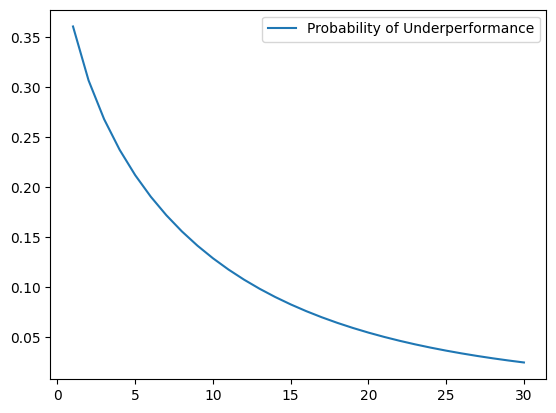

In [34]:
agg_years = [(1965, 2023)]
res_stats_long = np.log(1 + data).apply(calc_analytics_by_year, periods=agg_years).T
mu, sigma = res_stats_long.loc['excess_returns']

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu, sigma, 15):,.2%}')
print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu, sigma, 30):,.2%}')

# precise probability
h = np.arange(1, 31)
probabilities = pd.DataFrame(prob(mu, sigma, h), index=h, columns=['Probability of Underperformance'])
probabilities.plot()

## 3.4

Let's consider how things turned out relative to Barnstable's 1999 expectations.
- (a) What was the probability (based on the 1999 estimate of $\mu$,) that the 23-year market return, $R_{t, t+23}^M$, would be smaller than that realized in 2000-2023? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.
- (b) Suppose Barnstable had implemented the put-option strategy with the growing strike of $6 \%$ ? Based on the 2000-2023 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of $\mu, \sigma$ to be the estimates based on 1965-2023.

In [36]:
mu_diff = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2023', 'mean')].loc[('logs', 'SPX')]
sigma_diff = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]
print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu_diff, sigma_diff, 24):,.2%}')

SPX underperforming RF in the next 15 years after 1999: 5.07%


**Note for solving (b):**

For next 6 years (2024 ~ 2029), calculate the probability of the cummulative market return being lower than the strike grows of the put option.

$$P\left(\Pi_{t=2000}^{2029} (1+r_t^M) < 1.06^{30}\right)$$


- log-growth of put strike as $\mathrm{r}_G = \log(1.06)$.
- We know $\mu$ and $\sigma$ of $\mathrm{r}^M$ from 1965 - 2023
- We know the performance during 2000 - 2023. 
  - Let the mean of the log return during 2000 - 2023 as $\mu_{perf} = \frac{1}{24}\sum_{t=2000}^{2023}\mathrm{r}_t^M = \frac{1}{24}\mathrm{r}_{2000, 2023}^M$

What we want to calculate is

$$
\begin{aligned}
P(\mathrm{r}_{2000, 2029}^M < 30\mathrm{r}_G)
&= P(\mathrm{r}_{2000, 2023}^M + \mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - \mathrm{r}_{2000, 2023}^M)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - 24\mu_{perf})\\
&= P(\mathrm{r}_{2024, 2029}^M < 24(\mathrm{r}_G - \mu_{perf}) + 6\mathrm{r}_G)\\
&= P(1/6 \times \mathrm{r}_{2024, 2029}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
&= P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
\end{aligned}
$$

Using annualized log return $\mathrm{r}^M \sim \mathcal{N}(\mu, \sigma^2)$ and $\mathrm{r}_{2024, 2029}^M \sim \mathcal{N}(6\mu, 6\sigma^2)$,

$$\bar{\mathrm{r}}^M \sim \mathcal{N}\left(\mu, \frac{1}{6}\sigma^2\right)$$

So, we can calculate the probability as

$$
P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G) = \Phi_{\mathcal{N}}\left( -\frac{\frac{24}{6}(\mu_{perf} - \mathrm{r}_G) +  \mu- \mathrm{r}_G}{\sigma/\sqrt{6}}\right)
$$

We can also decompose the target as two part
- $\frac{24}{6}(\mu_{perf} - \mathrm{r}_G)$ : How much we have been over-performing relative to the strike growth
- $\mu - \mathrm{r}_G$ : How much we need to perform relative to the strike growth

In [39]:
strike = np.log(1.06)
mean_return = np.log(1 + data['SPX'].loc['1965':]).mean() * 12
sigma = np.log(1 + data['SPX'].loc['1965':]).std() * np.sqrt(12)
performance = np.log(1 + data['SPX'].loc['2000':]).mean() * 12
mu = 24 / 6 * (strike - performance) + strike - mean_return

print(f'Probability of Puts ending in the money: {prob(mu, sigma, 6):,.2%}')

Probability of Puts ending in the money: 89.12%
